In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split

In [171]:
data = pd.read_csv("/work/ptyagi/masterthesis/data/predictions/aug/analysis_metrics.csv")
replies_df = pd.read_csv('/work/ptyagi/masterthesis/data/predictions/aug/predictions_replies_cardiffnlp_twitter-roberta-large-emotion-latest_merged.csv')


In [172]:
data['clip_distribution'] = data['clip_distribution'].apply(ast.literal_eval)
data['average_reply_distribution'] = data['average_reply_distribution'].apply(ast.literal_eval)
data['tweet_distribution'] = data['tweet_distribution'].apply(ast.literal_eval)
data['clip_tweet_dist'] = data['clip_tweet_dist'].apply(ast.literal_eval)
data['average_reply_distribution'] = data['average_reply_distribution'].apply(lambda d: {k: round(v, 8) for k, v in d.items()})
data['tweet_distribution'] = data['tweet_distribution'].apply(lambda d: {k: round(v, 8) for k, v in d.items()})
data['clip_tweet_dist'] = data['clip_tweet_dist'].apply(lambda d: {k: round(v, 8) for k, v in d.items()})

In [173]:
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, tweets_df = train_test_split(temp_data, test_size=1/3, random_state=42)

In [174]:
def parse_distribution(dist_str):
    return dict(ast.literal_eval(dist_str))
tweets_df['roberta_pred_dist'] = tweets_df['roberta-large-predictions'].apply(parse_distribution)

In [175]:
df = pd.read_csv("/work/ptyagi/masterthesis/data/baseline_aug.csv")
df['predictions_text'] = df['predictions_text'].apply(parse_distribution)
df['predictions_image'] = df['predictions_image'].apply(parse_distribution)
df['predictions_multi'] = df['predictions_multi'].apply(parse_distribution)
tweets_df = pd.merge(tweets_df, df, on='conversation_id', how='inner')
tweets_df['predictions_text'] = tweets_df['predictions_text'].apply(lambda d: {k: round(v, 8) for k, v in d.items()})
tweets_df['predictions_image'] = tweets_df['predictions_image'].apply(lambda d: {k: round(v, 8) for k, v in d.items()})
tweets_df['predictions_multi'] = tweets_df['predictions_multi'].apply(lambda d: {k: round(v, 8) for k, v in d.items()})

In [176]:
def reorder_dict(d, order):
    return {key: d[key] for key in order if key in d}

tweets_df['predictions_text'] = tweets_df['predictions_text'].apply(lambda x: reorder_dict(x, ['anger', 'fear', 'surprise', 'disgust', 'sadness', 'joy' ]))
tweets_df['predictions_image'] = tweets_df['predictions_image'].apply(lambda x: reorder_dict(x, ['anger', 'fear', 'surprise', 'disgust', 'sadness', 'joy' ]))
tweets_df['predictions_multi'] = tweets_df['predictions_multi'].apply(lambda x: reorder_dict(x, ['anger', 'fear', 'surprise', 'disgust', 'sadness', 'joy' ]))


In [177]:
emotion_mapping = {
    "anger": "anger",
    "anticipation": "surprise", 
    "disgust": "disgust",
    "fear": "fear",
    "joy": "joy",
    "love": "joy",           
    "optimism": "joy",       
    "pessimism": "fear",     
    "sadness": "sadness",
    "surprise": "surprise",
    "trust": "joy"           
}
def visualize_tweets(data, start_idx=0, rows=1, cols=2):
    """
    Visualizes tweets and images for a specified index range.
    
    Parameters:
        data: DataFrame containing tweet information
        start_idx: Starting index of the range
        end_idx: Ending index of the range (exclusive)
        rows: Number of rows in the plot grid
        cols: Number of columns in the plot grid
    """
    end_idx=start_idx+2
    batch_data = data.iloc[start_idx:end_idx]

    if batch_data.empty:
        print("No tweets found in the specified index range.")
        return

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    axes = axes.flatten()  # Flatten for easy indexing

    categories = ['anger', 'fear', 'surprise', 'disgust', 'sadness', 'joy' ]
    
    for i, (index, row) in enumerate(batch_data.iterrows()):
        print(row['conversation_id']) 
        # Get tweet details
        tweet_text = row["tweet_text"]
        tweet_distribution = row["tweet_distribution"]
        clip_distribution = row["clip_distribution"]
        ordered_dict = {key: clip_distribution[key] for key in categories}
        multi_distribution = row["clip_tweet_dist"]
        ordered_dict_0 = {key: multi_distribution[key] for key in categories}
        predicted_text = row['predictions_text']
        predicted_image = row['predictions_image']
        predicted_multi = row['predictions_multi']
        avg_dist = row["average_reply_distribution"]
        image_path = f'/work/ptyagi/ClimateVisions/Images/2019/08_August/{row["matched_filename"]}'

        try:
            image = Image.open(image_path)
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(f"Tweet ID: {row['conversation_id']}", fontsize=8)
        except FileNotFoundError:
            print(f"Image not found for conversation_id: {row['conversation_id']}")
            axes[i].axis('off')
            axes[i].set_title("Image Not Found", fontsize=8)

        # Print details in console for analysis
        print(f"Tweet {i + 1}: {tweet_text}")
        print(f"Base Text: {tweet_distribution}")
        print(f"Base Image: {ordered_dict}")
        print(f"Base Multi: {ordered_dict_0}")
        print(f"Predicted Text: {predicted_text}")
        print(f"Predicted Image: {predicted_image}")
        print(f"Predicted Multi: {predicted_multi}")
        print(f"reply Distribution: {avg_dist}")
        print("-" * 50)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Explicitly close the figure to release resources



In [178]:
tweets_df.columns

Index(['conversation_id', 'tweet_text', 'roberta-large-predictions',
       'averaged_predictions', 'mapped_predictions',
       'cosine_similarity_tweet_replies', 'clip_predictions',
       'cosine_similarity_clip_replies', 'cosine_similarity_clip_tweet',
       'similarity_bin', 'matched_filename', 'tweet_distribution',
       'average_reply_distribution', 'clip_distribution', 'clip_tweet_dist',
       'cosine_similarity_multi', 'jsd', 'jsd_image', 'jsd_multi',
       'jsd_image_reply', 'tweet_entropy', 'reply_entropy', 'multi_entropy',
       'roberta_pred_dist', 'predictions_text', 'cosine_similarity_model_text',
       'kl_divergence_text', 'mean_squared_error_text', 'predictions_image',
       'cosine_similarity_model_image', 'kl_divergence_image',
       'mean_squared_error_image', 'predictions_multi',
       'cosine_similarity_model_multi', 'kl_divergence_multi',
       'mean_squared_error_multi'],
      dtype='object')

In [179]:
top_model_sim = tweets_df.sort_values('cosine_similarity_model_multi', ascending=False).head(50)

filtered_df = top_model_sim.sort_values('cosine_similarity_tweet_replies', ascending=True).head(50)

# Step 3: Extract conversation IDs and filter tweets_df
dff = tweets_df[tweets_df['conversation_id'].isin(filtered_df['conversation_id'].to_list())].copy()


In [180]:
dff = tweets_df[tweets_df['conversation_id'].isin(df.sort_values('cosine_similarity_model_multi', ascending=True)['conversation_id'][:50].to_list())].copy()

1166008123263475712
Tweet 1: #AlTenoorOverflow #Africafires#Angola#Zambia#Tanzania#CongoLinks to the #SkirmishEvents statements in multiple languages:[URL] [URL]
Base Text: {'anger': 0.21514056, 'fear': 0.15376969, 'surprise': 0.34307328, 'disgust': 0.11004311, 'sadness': 0.09483379, 'joy': 0.08313957}
Base Image: {'anger': 0.26606992, 'fear': 0.3789367, 'surprise': 0.12640072, 'disgust': 0.11808189, 'sadness': 0.05766713, 'joy': 0.052843694}
Base Multi: {'anger': 0.24060524, 'fear': 0.2663532, 'surprise': 0.234737, 'disgust': 0.1140625, 'sadness': 0.07625046, 'joy': 0.06799163}
Predicted Text: {'anger': 0.17008963, 'fear': 0.15321772, 'surprise': 0.2238833, 'disgust': 0.1150547, 'sadness': 0.16288464, 'joy': 0.17486995}
Predicted Image: {'anger': 0.11810187, 'fear': 0.2317289, 'surprise': 0.26663852, 'disgust': 0.11301755, 'sadness': 0.11795535, 'joy': 0.15255782}
Predicted Multi: {'anger': 0.1088891, 'fear': 0.27045786, 'surprise': 0.2549178, 'disgust': 0.0991774, 'sadness': 0.105980

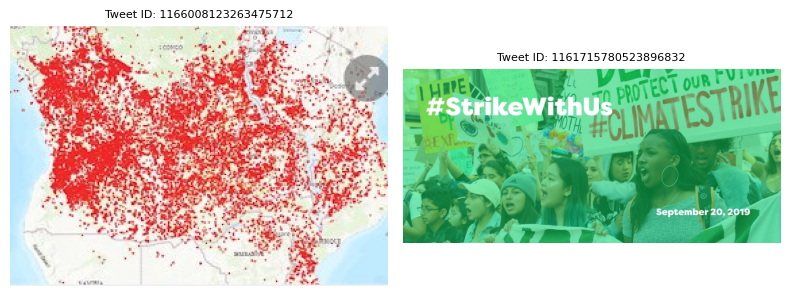

In [181]:
visualize_tweets(dff)

In [182]:
dff = tweets_df[tweets_df['conversation_id'].isin(df.sort_values('cosine_similarity_model_multi', ascending=False)['conversation_id'][:50].to_list())].copy()

1158365774362415110
Tweet 1: #Arctic sea ice volume broke another record minimum for July with an average of 8,808 km³. That's less than *half* of what it was just 20 years ago. #climatechange #climatecrisis #dataviz [URL]
Base Text: {'anger': 0.03449092, 'fear': 0.33497405, 'surprise': 0.07675052, 'disgust': 0.14919708, 'sadness': 0.37493542, 'joy': 0.02965201}
Base Image: {'anger': 0.42797083, 'fear': 0.07884965, 'surprise': 0.078710586, 'disgust': 0.04076117, 'sadness': 0.31480962, 'joy': 0.058898173}
Base Multi: {'anger': 0.23123087, 'fear': 0.20691185, 'surprise': 0.07773055, 'disgust': 0.09497913, 'sadness': 0.34487252, 'joy': 0.04427509}
Predicted Text: {'anger': 0.15565357, 'fear': 0.13766329, 'surprise': 0.2134843, 'disgust': 0.13057688, 'sadness': 0.20684318, 'joy': 0.1557788}
Predicted Image: {'anger': 0.1073963, 'fear': 0.27420822, 'surprise': 0.27890724, 'disgust': 0.10312987, 'sadness': 0.1066079, 'joy': 0.12975046}
Predicted Multi: {'anger': 0.09921451, 'fear': 0.2918184

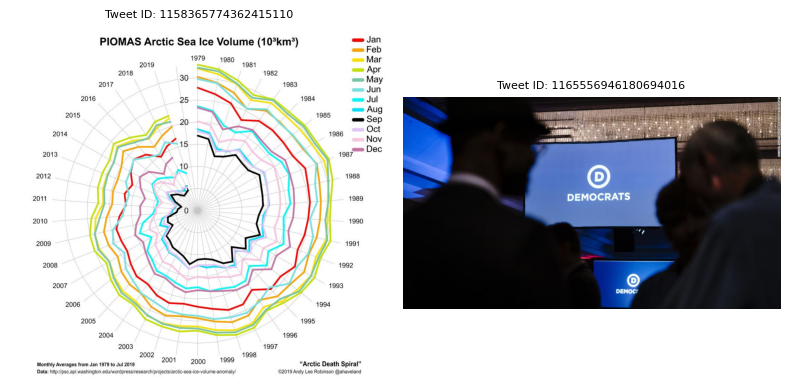

In [183]:
visualize_tweets(dff,2)

1157376772901658624
Tweet 1: “We also need to start moving our people to higher ground.”Democratic candidate Andrew Yang suggests a plan to deal with climate change, but it only solves one type of climate-induced problem. [USER] [URL] [URL]
Tweet Distribution: {'anger': 0.01354075, 'fear': 0.06671371, 'surprise': 0.34435361, 'disgust': 0.07928324, 'sadness': 0.06889568, 'joy': 0.42721301}
CLIP Distribution: {'anger': 0.09006591, 'fear': 0.16456114, 'surprise': 0.48688015, 'disgust': 0.16805072, 'sadness': 0.0664596, 'joy': 0.023982478}
Average Distribution: {'anger': 0.05180333, 'fear': 0.11563742, 'surprise': 0.41561688, 'disgust': 0.12366698, 'sadness': 0.06767764, 'joy': 0.22559774}
Predicted Distribution: {'anger': 0.14817593, 'fear': 0.24291989, 'surprise': 0.24850084, 'disgust': 0.07841087, 'sadness': 0.08033644, 'joy': 0.20165598}
reply Distribution: {'anger': 0.20520739, 'fear': 0.03746645, 'surprise': 0.24891454, 'disgust': 0.17749465, 'sadness': 0.05875903, 'joy': 0.27215794}

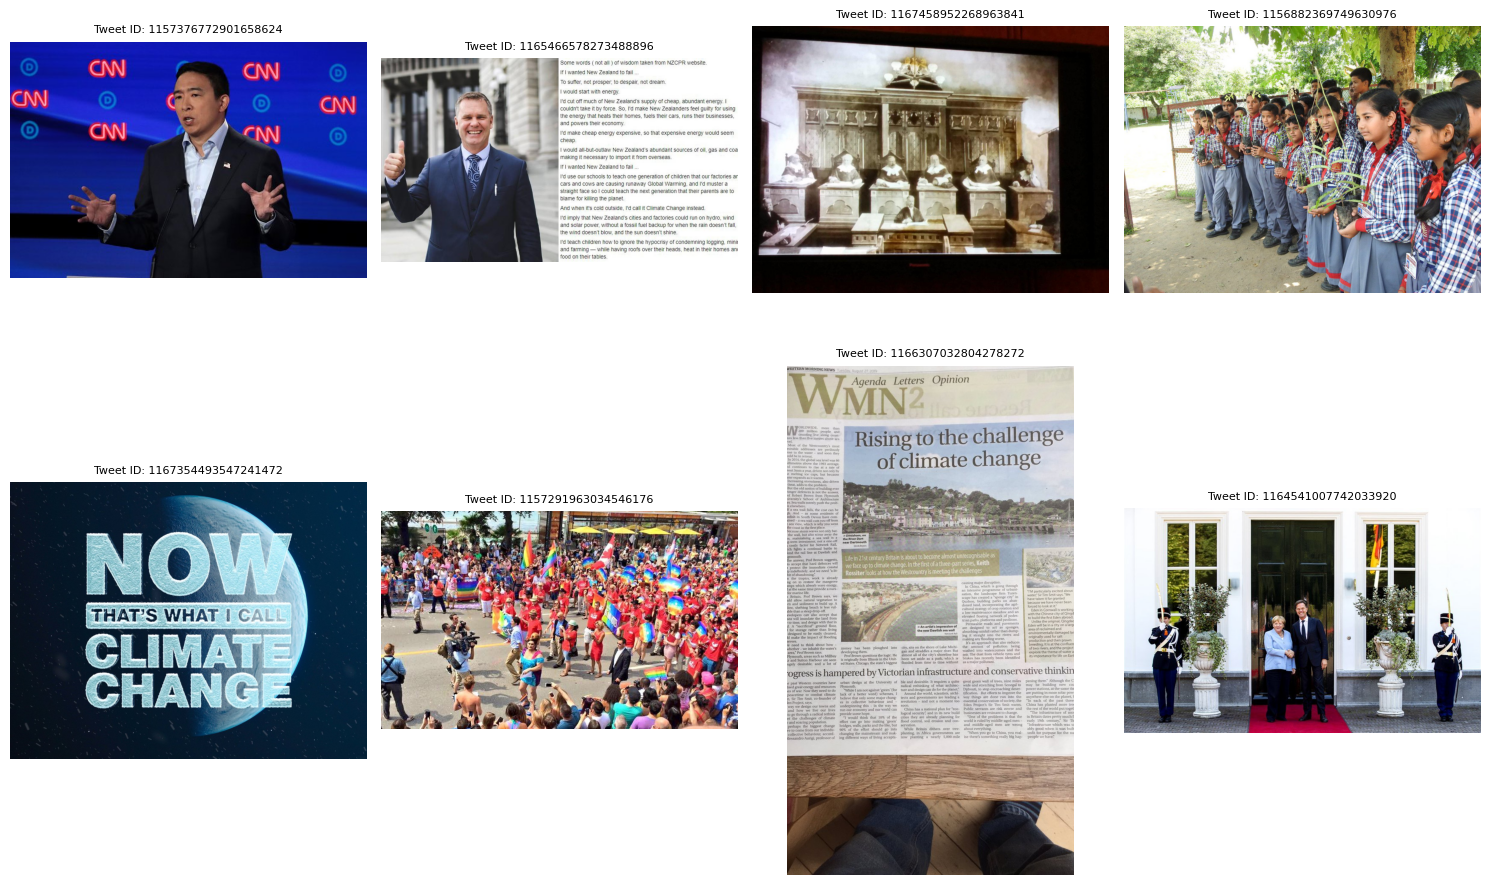

In [56]:
dff = tweets_df[tweets_df['conversation_id'].isin(df.sort_values('cosine_similarity_model', ascending=False)['conversation_id'][:50].to_list())].copy()
visualize_tweets(dff, 16, 24)

Baseline Accuracy: 0.5051
After Training Accuracy: 0.5354
Accuracy Improvement: 0.0303

Per-Class Accuracy Comparison:
            Baseline Accuracy  After Training Accuracy
True Label                                            
anger                0.666667                 0.757576
disgust              0.400000                 0.266667
fear                 0.307692                 0.307692
joy                  0.875000                 0.875000
sadness              0.083333                 0.083333
surprise             0.300000                 0.500000

Average Confidence Score Change: -0.055192929090909094


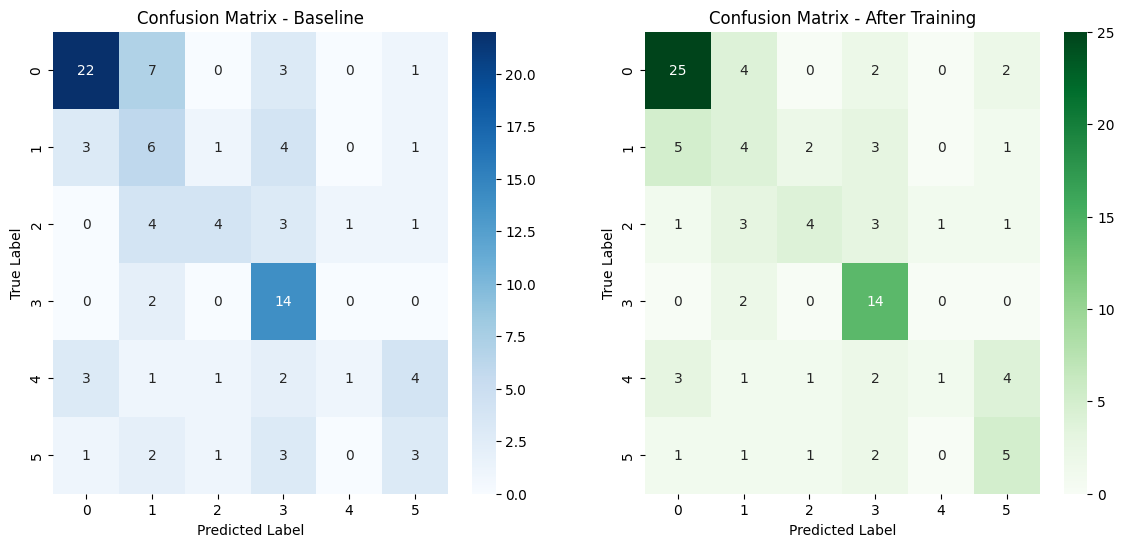


Misclassified Examples Before Training:
                                                Text True Label  \
1  hello ladies and gentleman i did a poem known ...    sadness   
2  climate change is real and nature will respond...       fear   
3  i can not wait right now for the climate chang...   surprise   
4  is too stupid to understand maybe if they watc...      anger   
5  i fully expected meghans head to spin around c...      anger   

  Predicted Label  Confidence Score  
1             joy          0.632773  
2             joy          0.993930  
3           anger          0.705469  
4         disgust          0.587446  
5         disgust          0.579504  

Misclassified Examples After Training:
                                                Text True Label  \
1  hello ladies and gentleman i did a poem known ...    sadness   
2  climate change is real and nature will respond...       fear   
3  i can not wait right now for the climate chang...   surprise   
8  emember when the 

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load baseline and after-training CSVs
baseline_df = pd.read_csv("/work/ptyagi/masterthesis/src/notebooks/bert_baseline_predictions_test.csv")
after_training_df = pd.read_csv("/work/ptyagi/masterthesis/src/notebooks/bert_predictions_test.csv")

# Ensure both files have the same texts for comparison
assert list(baseline_df["Text"]) == list(after_training_df["Text"]), "Mismatch in text entries!"

# Compute accuracy before and after training
baseline_accuracy = accuracy_score(baseline_df["True Label"], baseline_df["Predicted Label"])
after_training_accuracy = accuracy_score(after_training_df["True Label"], after_training_df["Predicted Label"])

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"After Training Accuracy: {after_training_accuracy:.4f}")
print(f"Accuracy Improvement: {after_training_accuracy - baseline_accuracy:.4f}")

# Compute per-class accuracy
def per_class_accuracy(df):
    correct_preds = df[df["True Label"] == df["Predicted Label"]].groupby("True Label").size()
    total_per_class = df.groupby("True Label").size()
    return (correct_preds / total_per_class).fillna(0)

baseline_per_class = per_class_accuracy(baseline_df)
after_training_per_class = per_class_accuracy(after_training_df)

per_class_comparison = pd.DataFrame({
    "Baseline Accuracy": baseline_per_class,
    "After Training Accuracy": after_training_per_class
})
print("\nPer-Class Accuracy Comparison:")
print(per_class_comparison)

# Compute confidence score changes
baseline_df["Confidence Score Change"] = after_training_df["Confidence Score"] - baseline_df["Confidence Score"]

print("\nAverage Confidence Score Change:", baseline_df["Confidence Score Change"].mean())

# Confusion matrix before and after training
baseline_conf_matrix = confusion_matrix(baseline_df["True Label"], baseline_df["Predicted Label"], labels=np.unique(baseline_df["True Label"]))
after_training_conf_matrix = confusion_matrix(after_training_df["True Label"], after_training_df["Predicted Label"], labels=np.unique(after_training_df["True Label"]))

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(baseline_conf_matrix, annot=True, fmt="d", ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix - Baseline")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(after_training_conf_matrix, annot=True, fmt="d", ax=axes[1], cmap="Greens")
axes[1].set_title("Confusion Matrix - After Training")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

# Show misclassified texts before and after training
misclassified_before = baseline_df[baseline_df["True Label"] != baseline_df["Predicted Label"]]
misclassified_after = after_training_df[after_training_df["True Label"] != after_training_df["Predicted Label"]]

print("\nMisclassified Examples Before Training:")
print(misclassified_before[["Text", "True Label", "Predicted Label", "Confidence Score"]].head())

print("\nMisclassified Examples After Training:")
print(misclassified_after[["Text", "True Label", "Predicted Label", "Confidence Score"]].head())

# Improvement in predictions
fixed_predictions = misclassified_before.merge(after_training_df, on="Text", suffixes=("_before", "_after"))
fixed_predictions = fixed_predictions[fixed_predictions["True Label_before"] == fixed_predictions["Predicted Label_after"]]

print(f"\nNumber of Misclassifications Fixed: {len(fixed_predictions)}")

# Generate classification reports
print("\nClassification Report - Baseline:")
print(classification_report(baseline_df["True Label"], baseline_df["Predicted Label"]))

print("\nClassification Report - After Training:")
print(classification_report(after_training_df["True Label"], after_training_df["Predicted Label"]))
